# Online Portfolio Selection

#### Group - 1

### Imports

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp


import eikon as ek  # the Eikon Python wrapper package
import numpy as np  # NumPy
import pandas as pd  # pandas
import cufflinks as cf  # Cufflinks
import configparser as cpp
cf.set_config_file(offline=True)
import seaborn as sns
import matplotlib.pyplot as plt

import string
import random
import pandas_market_calendars as mcal
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)
API_KEY = 'a7a5e5c05b6844b2ad4a5f2e2519308954f5889d'
ek.set_app_key(API_KEY)

2023-04-18 16:33:16,231 P[79585] [MainThread 8633774784] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2023-04-18 16:33:16,232 P[79585] [MainThread 8633774784] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2023-04-18 16:33:16,233 P[79585] [MainThread 8633774784] Error on handshake url http://127.0.0.1:None/api/handshake : UnsupportedProtocol("Request URL is missing an 'http://' or 'https://' protocol.")
2023-04-18 16:33:16,233 P[79585] [MainThread 8633774784] Port number was not identified, cannot send any request


### Simulation Data

Generate returns using a log-normal distribution.

<AxesSubplot: >

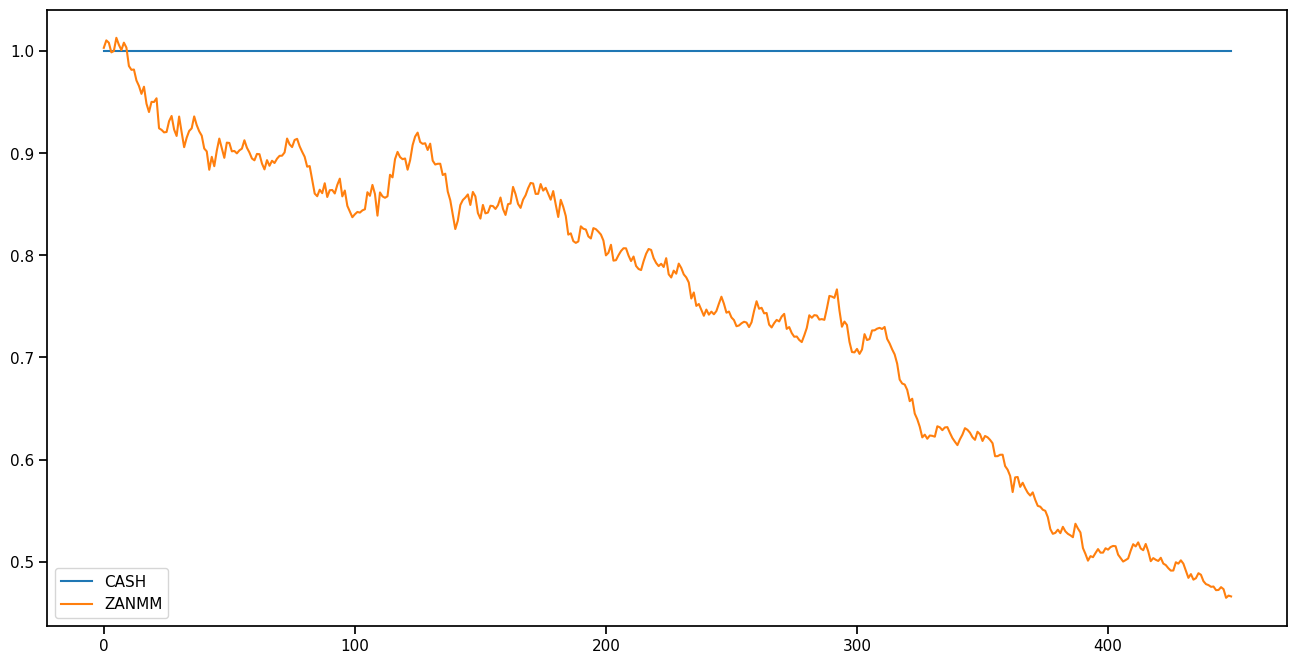

In [257]:
# Number of stocks
n = 1
# Create dummy stock labels
dummy_stocks = [''.join(random.choices(string.ascii_uppercase, k=5)) for i in range(n)]
# Number of trading days
T = 450


#Log-normal returns
r = np.exp(np.random.normal([-0.001], 0.01, size=(T,n)))
r = np.concatenate((np.ones((T,1)),r) , axis=1)
df = pd.DataFrame(data = r.cumprod(axis=0), columns = ["CASH"]+dummy_stocks)
df.plot()

For reproduciblity, we stored a particular simulation of geometric distribution for our experiments

<AxesSubplot: >

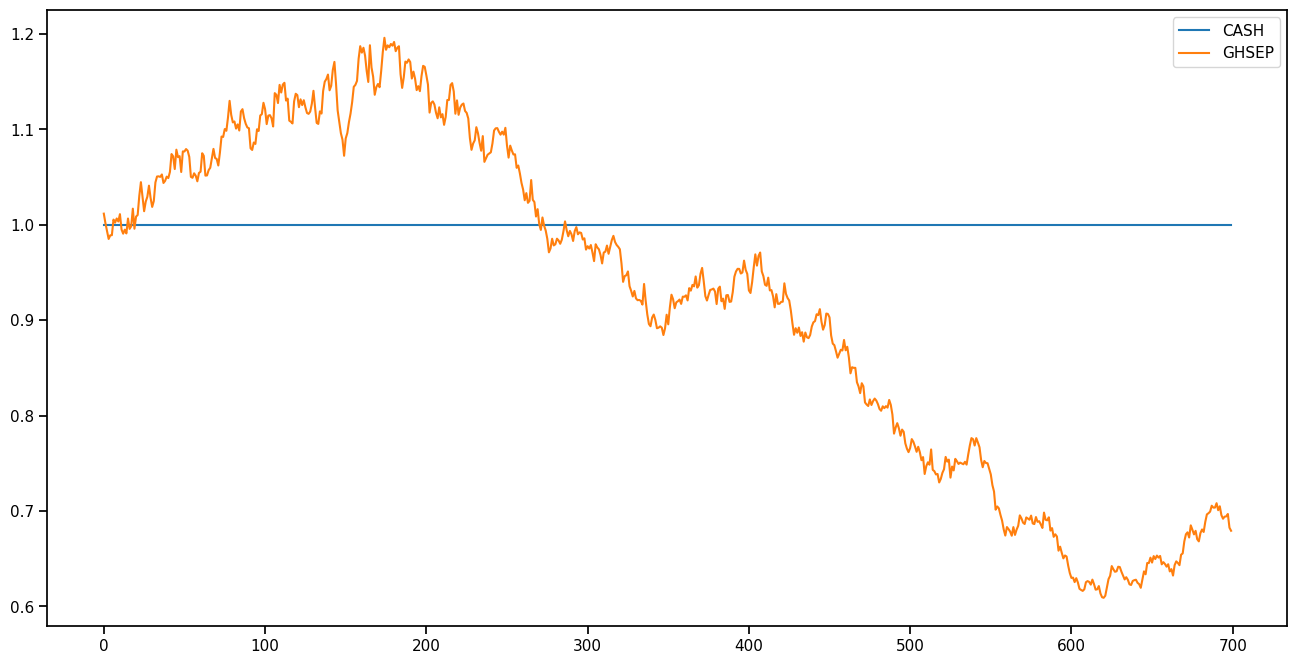

In [258]:
df1 = pd.read_csv('output.csv')
df1 = df1[["CASH","GHSEP"]]
df = 1+df1.pct_change().dropna()
df1.plot()

In [259]:
r = df.to_numpy()
df = df.cumprod()

### Algorithms

#### Best Constantly rebalanced portfolio (BCRP)

The Best Constantly rebalanced portfolio (BCRP) solves $$x^\star = \arg\max_{x\in \Delta_n} \sum_{t=1}^T \log (r_t^\top x)$$

In [260]:

def Best_Constantly_Rebalanced_Portfolio(r):

    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a


    x_minus = cp.Variable(n,nonneg=True)
    x_plus = cp.Variable(n,nonneg=True)
    x = x_plus-x_minus

    obj = cp.sum(cp.log( 1 +  (r[:,1:]-1)@(x[1:]) ) )
    prob = cp.Problem(cp.Maximize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1])
    prob.solve()
    return x_plus.value-x_minus.value



#### Follow the leader(FTL)

Follow the leader(FTL) solves $$x_t = \arg\max_{x\in \Delta_n} \sum_{i=1}^{t-1} \log(r_i^\top x)$$

FTL uses the BCRP on the returns seen so far.

In [261]:
def Follow_The_Leader(r):
    T = len(r)
    n = len(r[0])
    x = np.zeros((T,n))
    for t in range(T):
        try:
            x[t] = Best_Constantly_Rebalanced_Portfolio(r[:t])
        except:
            a = np.zeros(n)
            a[0]=1
            x[t]=a
    return x

In [262]:
ftl = Follow_The_Leader(r)
df['FTL'] = np.cumprod(1 + np.sum((r[:,1:]-1)*(ftl[:,1:]), axis=1))

Text(0.5, 1.0, 'Follow the leader Performance')

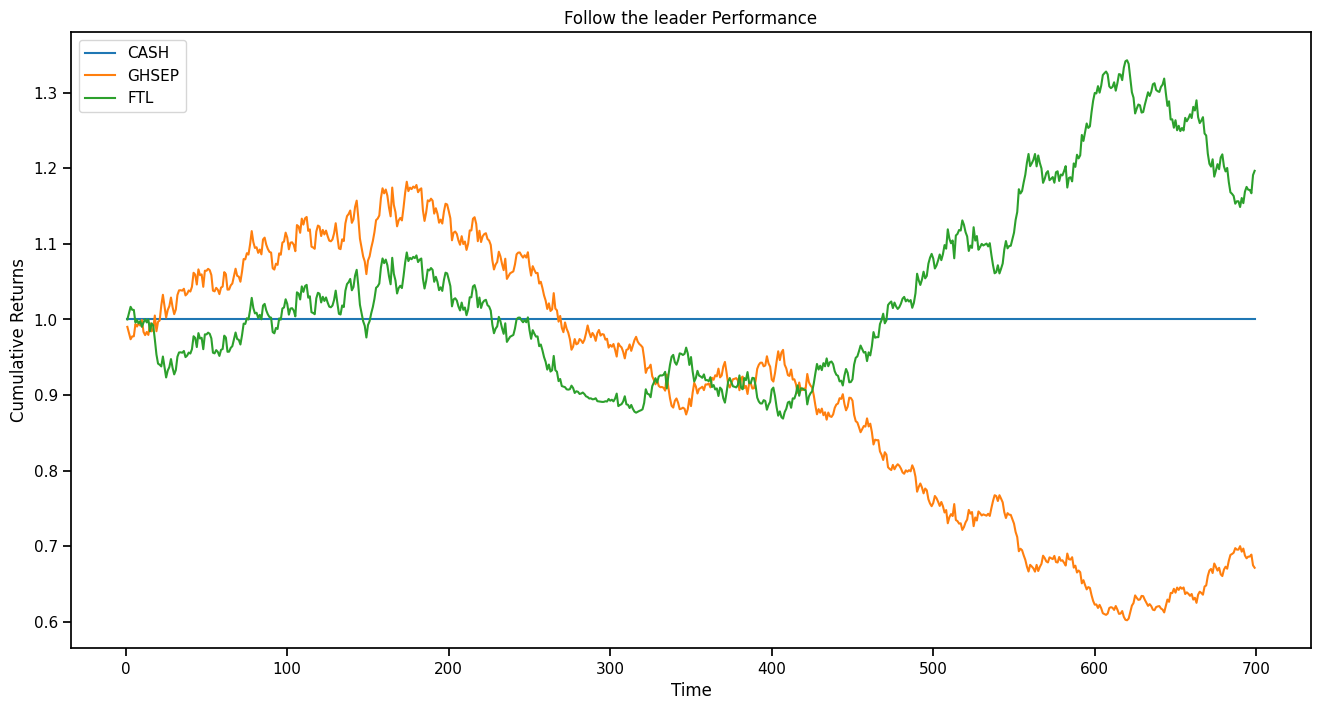

In [263]:
ax = df[["CASH","GHSEP","FTL"]].plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Follow the leader Performance')

Text(0.5, 1.0, 'Follow the Leader Portfolio')

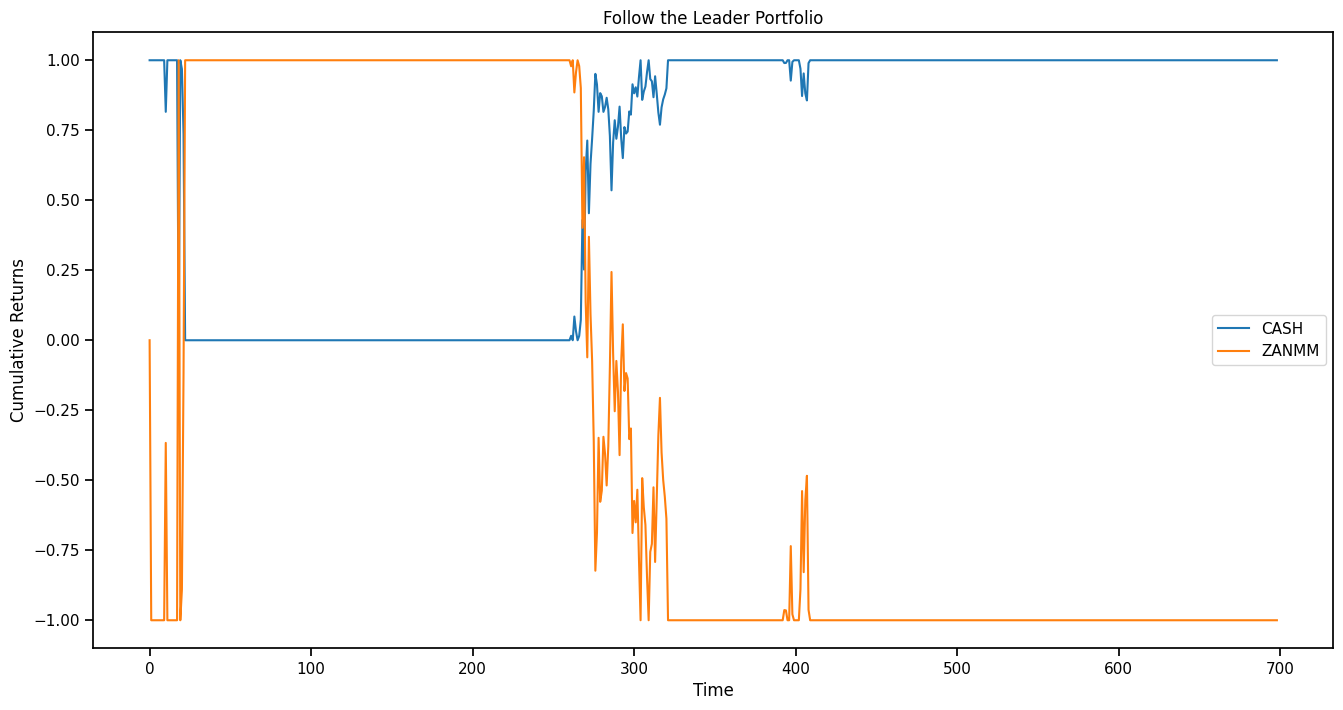

In [264]:
portfolio=pd.DataFrame(ftl,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Follow the Leader Portfolio')

As it can be seen above whichever asset performs better, the algorithm picks up that asset. The drawback of this algorithm is that the portfolio changes instantly

#### Follow The Regularized Leader

In [265]:
def Follow_The_Regularized_Leader_wrapper(r,f,reg):
    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a

    x_minus = cp.Variable(n,nonneg=True)
    x_plus = cp.Variable(n,nonneg=True)
    var_x = x_plus-x_minus
    obj = -cp.sum(cp.log( 1 +  (r[:,1:]-1)@(var_x[1:]) ) ) + (reg/2)*cp.sum(f(x_plus[1:])+f(x_minus[1:]))
    prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1 ])
    prob.solve()

    return x_plus.value-x_minus.value


def Follow_The_Regularized_Leader(r,f,reg=None):
    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a
    x = np.zeros((T,n))

    if reg is None:
        adap = True
        reg = 1
        grad_norm_squared_sum=0
    else:
        adap = False

    for t in range(T):
        y = Follow_The_Regularized_Leader_wrapper(r[:t], f, reg)
        x[t] = y

        gradient = - (r[t][1:]-1) /(1 + np.dot((r[t][1:]-1),x[t][1:]))
        grad_norm_squared_sum += np.linalg.norm(gradient)**2
        if adap is True:
            reg = np.sqrt(grad_norm_squared_sum)

    return x


#### Online Adaptive Gradient Descent

In [266]:
def Online_Gradient_Descent(r, f ,reg=None):
    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a

    x = np.zeros((T,n))
    gradient_sum = np.zeros(n-1)

    if reg is None:
        adap = True
        reg = 1
        grad_norm_squared_sum=0
    else:
        adap = False

    for t in range(T):

        x_minus = cp.Variable(n,nonneg=True)
        x_plus = cp.Variable(n,nonneg=True)
        var_x = x_plus-x_minus
        obj = gradient_sum @ var_x[1:] + (reg/2)*cp.sum(f(x_plus[1:])+f(x_minus[1:]))
        prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1 ])
        prob.solve()


        x[t] = x_plus.value-x_minus.value

        gradient = - (r[t][1:]-1) /(1 + np.dot((r[t][1:]-1),x[t][1:]))
        gradient_sum += gradient
        grad_norm_squared_sum += np.linalg.norm(gradient)**2
        if adap is True:
            reg = np.sqrt(grad_norm_squared_sum)

    return x

In [267]:
eg = Online_Gradient_Descent(r, lambda x: -1*cp.entr(x))
df['eg'] = np.cumprod(1 + np.sum((r[:,1:]-1)*(eg[:,1:]), axis=1))

Text(0.5, 1.0, 'Exponential Gradient Performance')

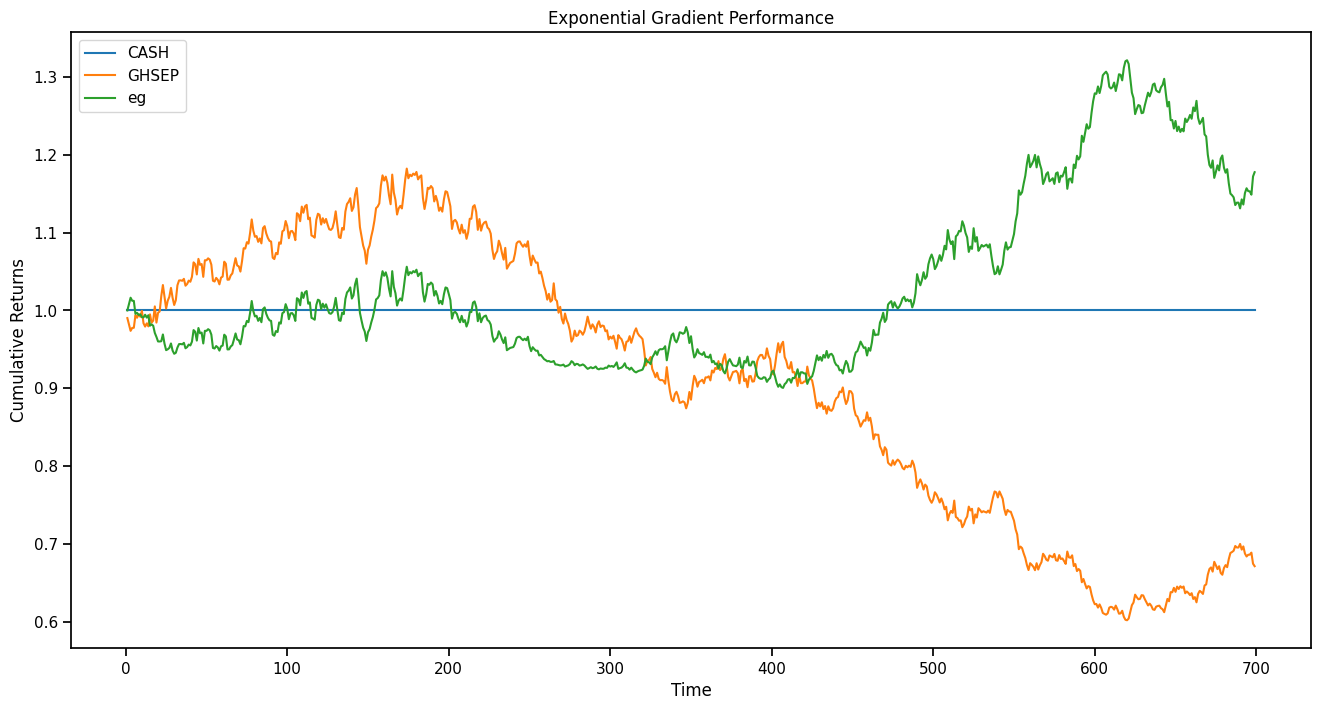

In [268]:
ax = df[["CASH","GHSEP","eg"]].plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Exponential Gradient Performance')

Text(0.5, 1.0, 'Exponential Gradient Portfolio')

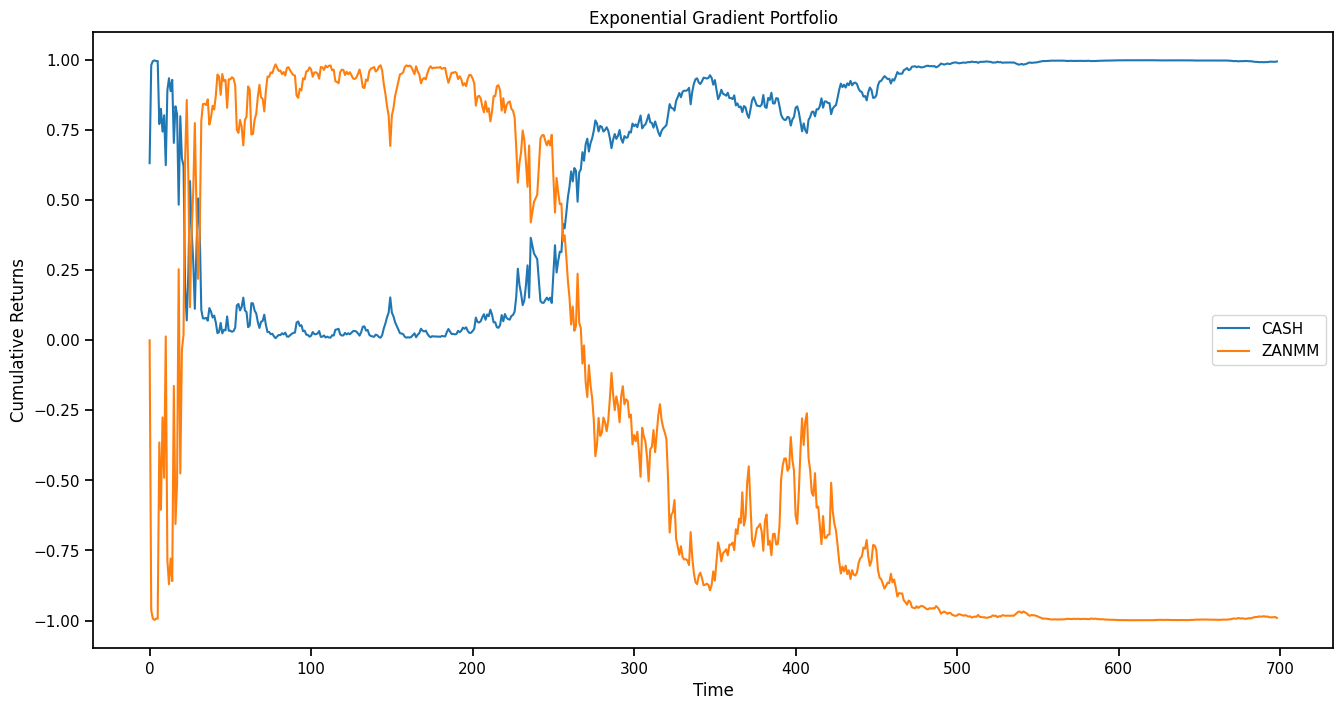

In [269]:
portfolio=pd.DataFrame(eg,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Exponential Gradient Portfolio')

This algorithm is very similar to the Follow the leader but the changes to portfolio aren't instant and takes place gradually

#### Online Newton Step


In [270]:
def Online_Newton_Step(r, f ,reg=None):
    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a

    x = np.zeros((T,n))
    gradient_sum = np.zeros(n-1)

    if reg is None:
        adap = True
        reg = 1
        grad_norm_squared_sum=0
    else:
        adap = False

    A=np.zeros((n-1,n-1))
    b=np.zeros(n-1)

    for t in range(T):

        x_minus = cp.Variable(n,nonneg=True)
        x_plus = cp.Variable(n,nonneg=True)
        var_x = x_plus-x_minus


        obj = (1/2)*cp.quad_form(var_x[1:], cp.psd_wrap(A) ) + b@var_x[1:] + (reg/2)*cp.sum(f(x_plus[1:])+f(x_minus[1:]))
        prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1 ])
        prob.solve()


        x[t] = x_plus.value-x_minus.value

        A +=  np.outer((r[t][1:]-1),(r[t][1:]-1)) /(1 + np.dot((r[t][1:]-1),x[t][1:]))
        b += -(r[t][1:]-1)

        gradient = - (r[t][1:]-1) /(1 + np.dot((r[t][1:]-1),x[t][1:]))
        gradient_sum += gradient
        grad_norm_squared_sum += np.linalg.norm(gradient)**2
        if adap is True:
            reg = np.sqrt(grad_norm_squared_sum)

    return x

In [271]:
ons = Online_Newton_Step(r, cp.square)
df['ons'] = np.cumprod(1 + np.sum((r[:,1:]-1)*(ons[:,1:]), axis=1))

Text(0.5, 1.0, 'Online Newton Step Performance')

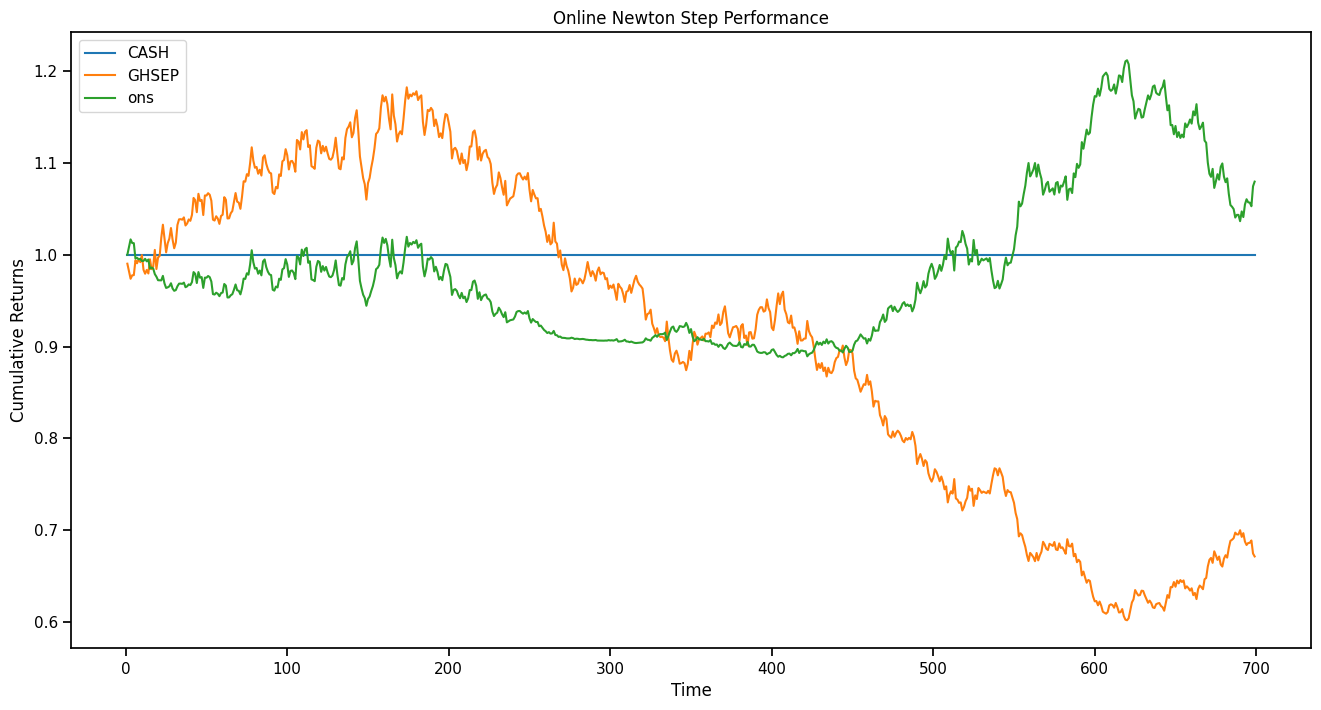

In [272]:
ax = df[["CASH","GHSEP","ons"]].plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Online Newton Step Performance')

Text(0.5, 1.0, 'Online Newton Step Portfolio')

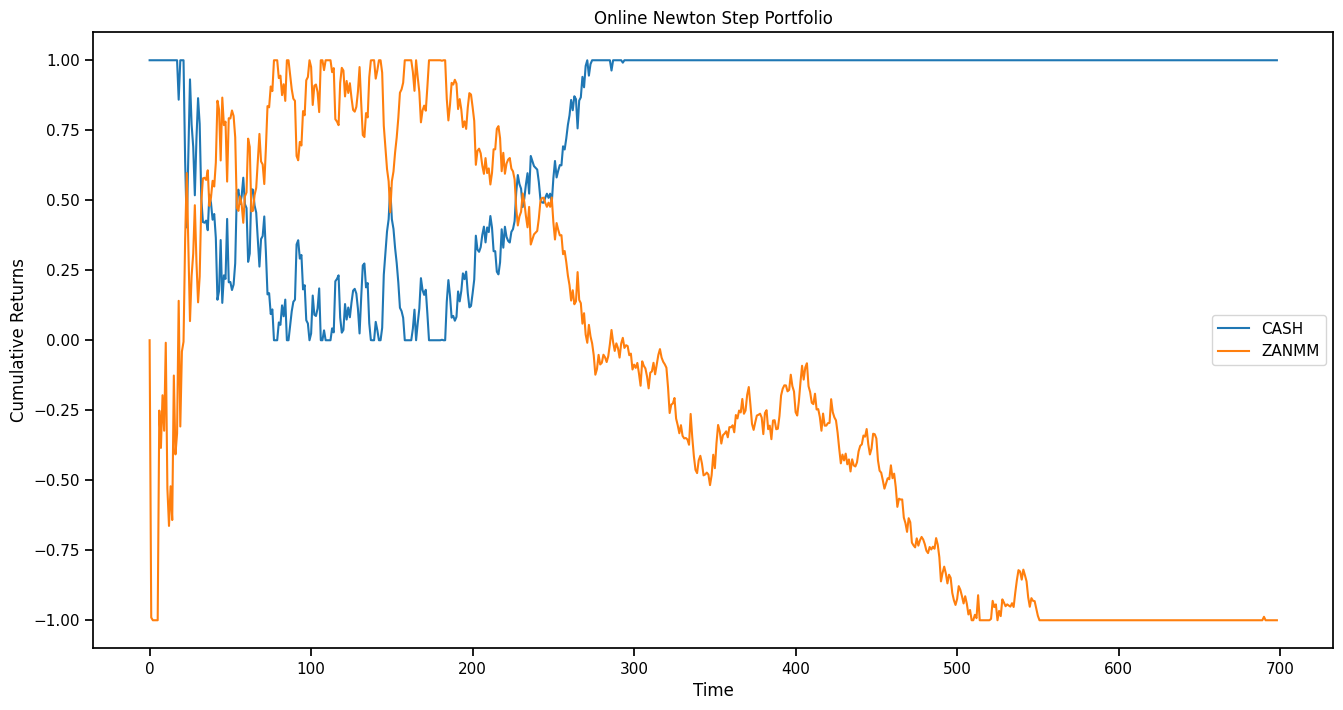

In [273]:
portfolio=pd.DataFrame(ons,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Online Newton Step Portfolio')

#### Implicit Online Mirror Descent

In [274]:
def Online_Mirror_Descent(r,f,reg=None):
    T = r.shape[0]
    n = r.shape[1]
    if T==0:
        a = np.zeros(n)
        a[0]=1
        return a
    x = np.zeros((T,n))
    x_p = np.ones((T,n))
    x_m = np.ones((T,n))

    if reg is None:
        adap = True
        reg = 1
        grad_norm_squared_sum=0
    else:
        adap = False

    a = np.zeros(n)
    a[0]=1
    x_t_plus_1 = a

    for t in range(T):
        x[t] = x_t_plus_1

        x_minus = cp.Variable(n,nonneg=True)
        x_plus = cp.Variable(n,nonneg=True)
        var_x = x_plus-x_minus

        gradient = - (r[t][1:]-1) /(1 + np.dot((r[t][1:]-1),x[t][1:]))
        grad_norm_squared_sum += np.linalg.norm(gradient)**2
        if adap is True:
            reg = np.sqrt(grad_norm_squared_sum)

        obj = -cp.log( 1 +  (r[t,1:]-1)@(var_x[1:]) )  + (reg/2)*cp.sum(f(x_plus[1:])+f(x_minus[1:]))
        prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1 ])
        prob.solve()

        x_t_plus_1 = x_plus.value-x_minus.value


    return x

#### Passive Aggressive Mean Reversion

This algorithm follows a mean reversion strategy and looks at the previous period return to find a portfolio. Idea is if portfolio makes negative return with previous period return, it is expected to mean-revert and provide positive in the next period.

Three different forms of the strategy was implemented. Initial version is the vanilla version and other two versions adds regularisation to ensure the portfolio between adjacent period doesn't change frequently.

In [275]:
def Passive_Aggressive_Mean_Reversion(w_t, r_t, epsilon = 0, C = 0, type = 'pamr'):

    l = max(0, (1 + w_t @ (r_t - 1)) - epsilon)
    e = 10e-6
    if type == 'pamr':
        tau = l/(np.sum(np.square(r_t - np.mean(r_t))) + e)
    elif type == 'pamr_1':
        tau = np.minimum(C, l/(np.sum(np.square(r_t - np.mean(r_t))) + e))
    elif type == 'pamr_2':
        tau = l/(np.sum(np.square(r_t - np.mean(r_t))) + 1/(2*C)  + e)

    w_t_new = w_t - tau*(r_t - np.mean(r_t))
    B = 1

    """Short Constraints"""
    x_minus = cp.Variable(len(w_t_new),nonneg=True)
    x_plus = cp.Variable(len(w_t_new),nonneg=True)
    x = x_plus-x_minus

    obj = cp.square(cp.norm2(w_t_new - x))
    prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B ])

    # prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0,  cp.sum(x_plus[:])+cp.sum(x_minus[1:]) <= 1 ])

    prob.solve(solver = cp.MOSEK)
    return x.value

def Passive_Aggressive_Mean_Reversion_OG(w_t, r_t, epsilon = 0, C = 0, type = 'pamr'):
    B = 1

    """Short Constraints"""
    if type == 'pamr':
        x_minus = cp.Variable(len(w_t),nonneg=True)
        x_plus = cp.Variable(len(w_t),nonneg=True)
        x = x_plus-x_minus

        obj = cp.square(cp.norm2(w_t - x))
        l = (1 + x @ (r_t - 1)) - epsilon
        #
        prob = cp.Problem(cp.Minimize(obj),
                          [x_minus[0]==0,
                           cp.sum(x_plus)==1,
                           cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B,
                           l <= 0
                           ]
                          )
    elif type == 'pamr_1':
        x_minus = cp.Variable(len(w_t),nonneg=True)
        x_plus = cp.Variable(len(w_t),nonneg=True)
        x = x_plus-x_minus
        eta  = cp.Variable(1, nonneg=True)
        obj = 1/2*cp.square(cp.norm2(w_t - x)) + C*eta
        l = (1 + x @ (r_t - 1)) - epsilon
        #
        prob = cp.Problem(cp.Minimize(obj),
                          [x_minus[0]==0,
                           cp.sum(x_plus)==1,
                           cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B,
                           l <= eta
                           ]
                          )

    elif type == 'pamr_2':
        x_minus = cp.Variable(len(w_t),nonneg=True)
        x_plus = cp.Variable(len(w_t),nonneg=True)
        x = x_plus-x_minus
        eta  = cp.Variable(1, nonneg=True)
        obj = 1/2*cp.square(cp.norm2(w_t - x)) + C*cp.square(eta)
        l = (1 + x @ (r_t - 1)) - epsilon
        #
        prob = cp.Problem(cp.Minimize(obj),
                          [x_minus[0]==0,
                           cp.sum(x_plus)==1,
                           cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B,
                           l <= eta
                           ]
                          )
    # x = cp.Variable(len(w_t))
    # prob = cp.Problem(cp.Minimize(obj), [cp.sum(x) == 1, x >= 0, l <= 0])
    # prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:]) <= 1 ])

    prob.solve(solver = cp.MOSEK)
    if prob.status != 'optimal':
        return w_t
    # print(prob.status)
    # print(l.value)
    return x.value

def PAMR(r, epsilon = 0, C = 0, type = 'pamr'):
    T = len(r)
    n = len(r[0])
    x = np.zeros((T,n))

    for t in range(T):
        # try:
        # print(t)
        if t == 0:
            x[t] = np.zeros(n)
            x[t][0] = 1
        else:
            x[t] = Passive_Aggressive_Mean_Reversion(x[t - 1], r[t - 1, :], epsilon, C, type = type)
        # except:
        #     print(t)
        #     x[t] = x[t - 1]
    return x





In [276]:
pamr = PAMR(r, epsilon = 0.99, C = 0, type = 'pamr')
df['PAMR'] =  np.cumprod(1 + np.sum((r - 1)*pamr, axis = 1))

pamr_1 = PAMR(r, epsilon = 0.9, C = 100, type = 'pamr_1')
df['PAMR_1'] = np.cumprod(1 + np.sum((r - 1)*pamr_1, axis = 1))


pamr_2 = PAMR(r, epsilon = 0.9, C = 1000, type = 'pamr_2')
df['PAMR_2'] = np.cumprod(1 + np.sum((r - 1)*pamr_2, axis = 1))



Text(0.5, 1.0, 'Passive Aggresive Mean Average (PAMR) Performance')

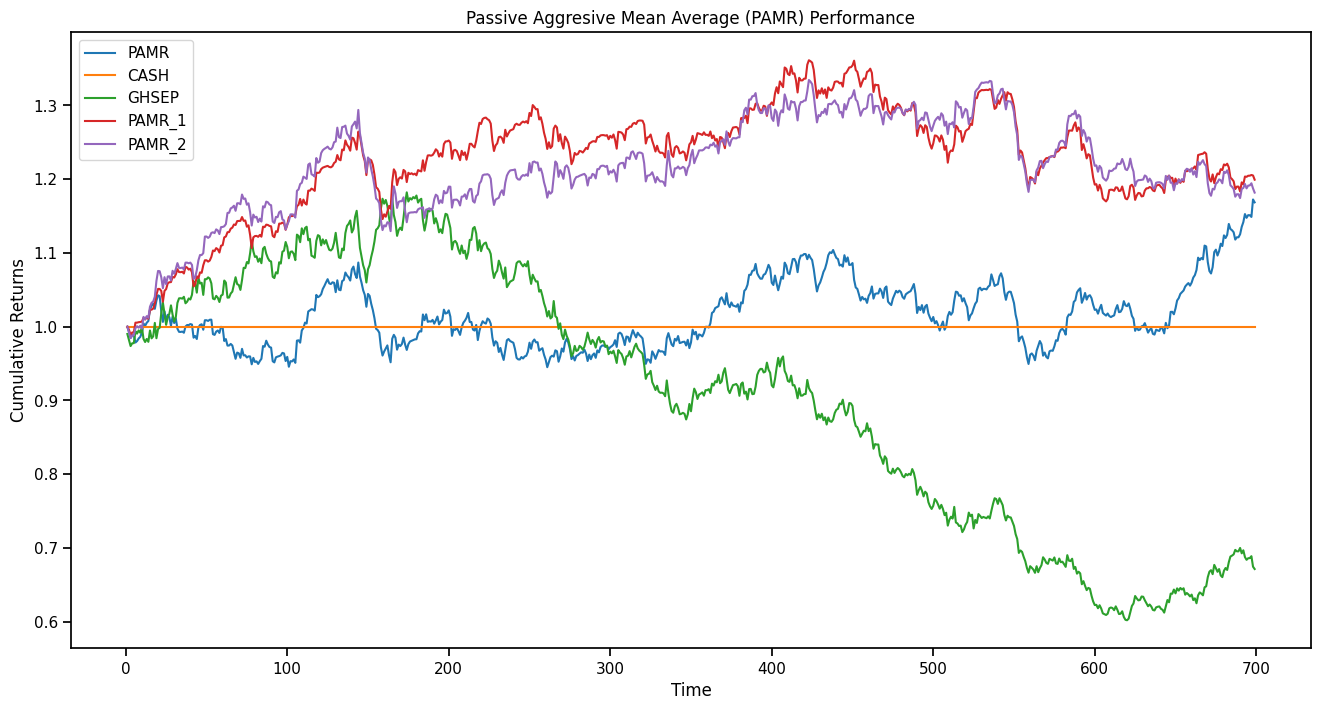

In [277]:
ax = df[['PAMR', 'CASH', 'GHSEP', 'PAMR_1', 'PAMR_2']].plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Passive Aggresive Mean Average (PAMR) Performance')

Text(0.5, 1.0, 'PAMR Portfolio')

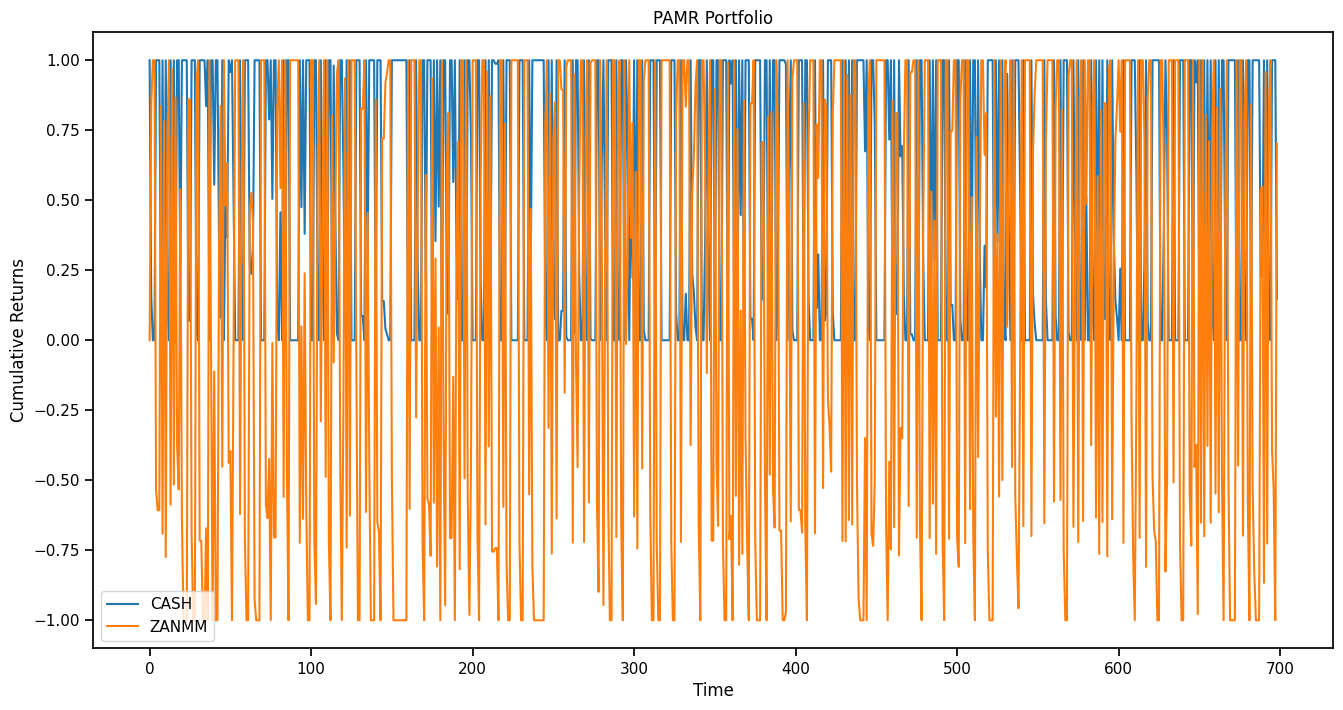

In [278]:
portfolio=pd.DataFrame(pamr,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('PAMR Portfolio')

Text(0.5, 1.0, 'PAMR Portfolio')

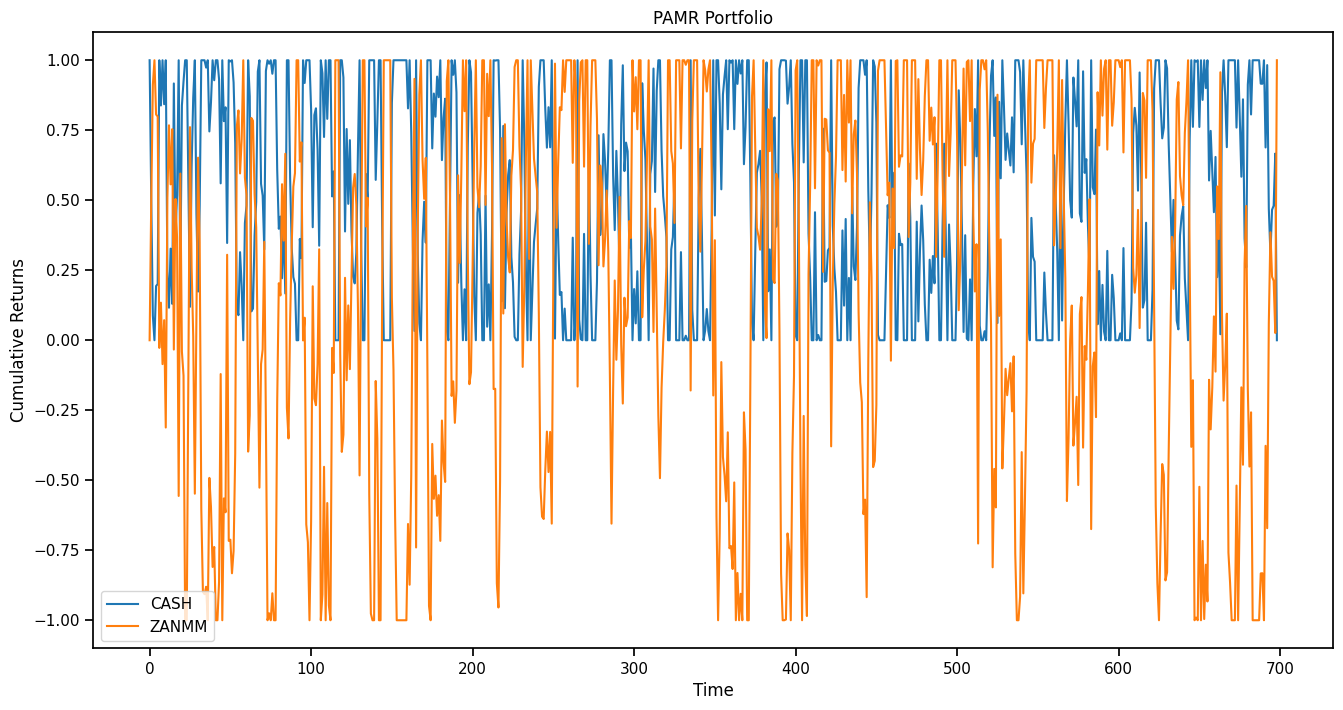

In [279]:
portfolio=pd.DataFrame(pamr_1,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('PAMR Portfolio')

Text(0.5, 1.0, 'PAMR-2 Portfolio')

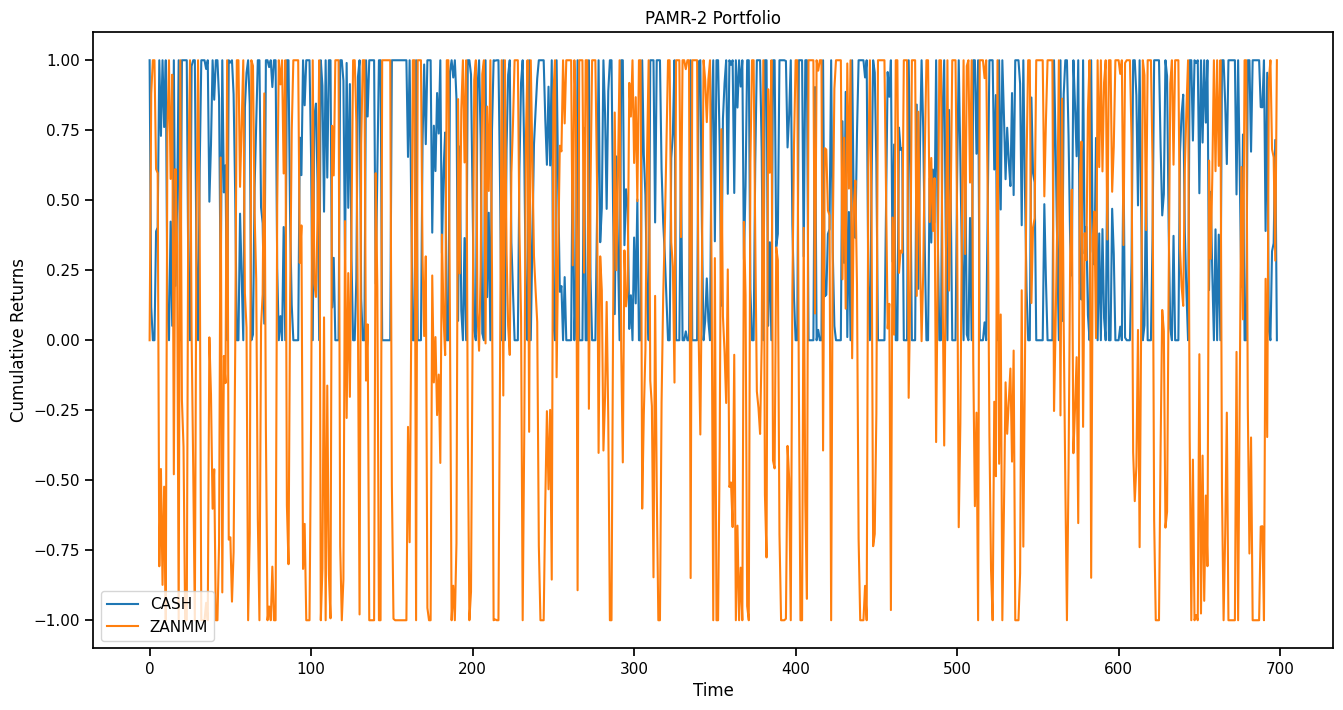

In [280]:
portfolio=pd.DataFrame(pamr_2,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('PAMR-2 Portfolio')

#### Online Moving Average Reversion

This algorithm is also a form of mean reverting strategy. In this case, mean of last few period prices was considered to be the price of next period. Based on the expected price calulcated, expected return for next period is calculated and used to find a portfolio for the next period.

To calculate the expected price for the next period, simple average and exponential average of the previous period price was used.

In [297]:
def Online_Moving_Average_Reversion(r, epsilon, window_size = None, alpha = None):
    T = len(r)
    n = len(r[0])
    x = np.zeros((T,n))
    r_t_1 = np.ones(n)
    e = 10e-6
    for t in range(T):
        if t == 0:
            x[t] = np.zeros(n)
            x[t][0] = 1
        else:
            if window_size is not None:
                # if t < window_size:
                #     x[t] = np.zeros(n)
                #     x[t][0] = 1
                # else:
                temp_window_size = min(t + 1, window_size)
                r_t_1 = (1 + (1/(r[t-temp_window_size + 1:t][::-1].cumprod(axis = 0) + e)).sum(axis = 0))/temp_window_size

            else:
                r_t_1 = alpha + (1 - alpha)*r_t_1/(r[t - 1] + e)
            # print(r_t_1, x[t - 1])
            x[t] = OLMAR(epsilon, r_t_1, x[t - 1])
    return x

def OLMAR(epsilon, r_t_1, w_t):
    e = 10e-6
    # lambd = max(0, (epsilon - (1 + w_t @ (r_t_1 - 1)))/(np.sum(np.square(r_t_1 - np.mean(r_t_1))) + e))
    # w_t_new = w_t - lambd*(r_t_1 - np.mean(r_t_1))
    #
    #
    # B = 1
    # x_minus = cp.Variable(len(w_t_new),nonneg=True)
    # x_plus = cp.Variable(len(w_t_new),nonneg=True)
    # x = x_plus-x_minus
    #
    # obj = cp.square(cp.norm2(w_t_new - x))
    # prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0, cp.sum(x_plus)==1,  cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B ])
    # prob.solve()

    try:
        B = 1
        x_minus = cp.Variable(len(w_t),nonneg=True)
        x_plus = cp.Variable(len(w_t),nonneg=True)
        x = x_plus-x_minus

        obj = cp.square(cp.norm2(w_t - x))
        r = (1 + x @ (r_t_1 - 1))
        prob = cp.Problem(cp.Minimize(obj), [x_minus[0]==0,
                                             cp.sum(x_plus)==1,
                                             cp.sum(x_plus[1:])+cp.sum(x_minus[1:])<=1/B,
                                             r >= epsilon
                                             ])
        # print(prob.status)
        prob.solve(solver = cp.MOSEK)
        # print(prob.status)
        if prob.status != 'optimal':
            return w_t
    except:
        return w_t
    return x.value


In [298]:
# OMAR_simple = Online_Moving_Average_Reversion(r, epsilon = 1.01 , window_size = 5, alpha = None)
# df['OMAR_simple'] = np.cumprod(1 + np.sum((r - 1)*OMAR_simple, axis = 1))
OMAR_simple = Online_Moving_Average_Reversion(r, epsilon=1.01, window_size=5, alpha=None)
df['OMAR_simple'] = np.cumprod(1 + np.sum((r - 1) * OMAR_simple, axis=1))

OMAR_exp = Online_Moving_Average_Reversion(r, epsilon = 1.01, alpha = 0.95)
df['OMAR_exp'] = np.cumprod(1 + np.sum((r - 1)*OMAR_exp, axis = 1))





Text(0.5, 1.0, 'Online Moving Average Performance')

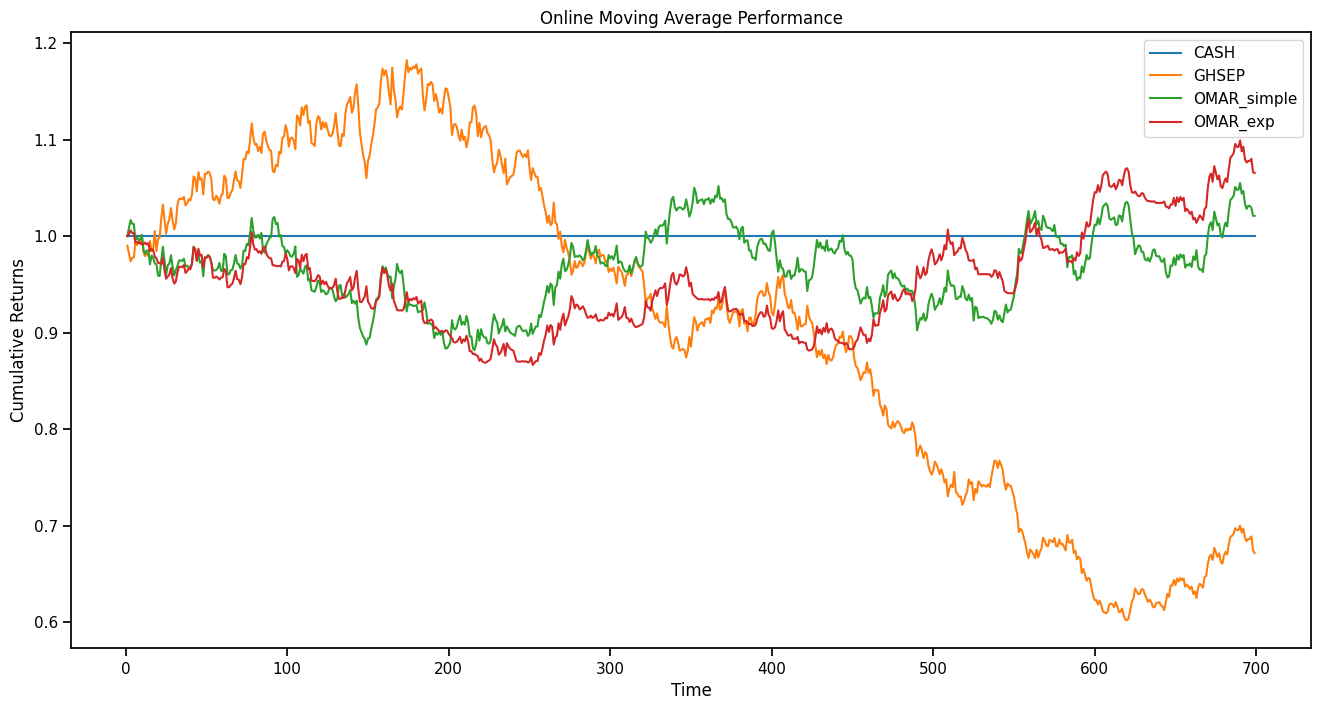

In [299]:
ax = df[[ 'CASH', 'GHSEP', 'OMAR_simple', 'OMAR_exp']].plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Online Moving Average Performance')


Text(0.5, 1.0, 'OLMAR Simple Portfolio')

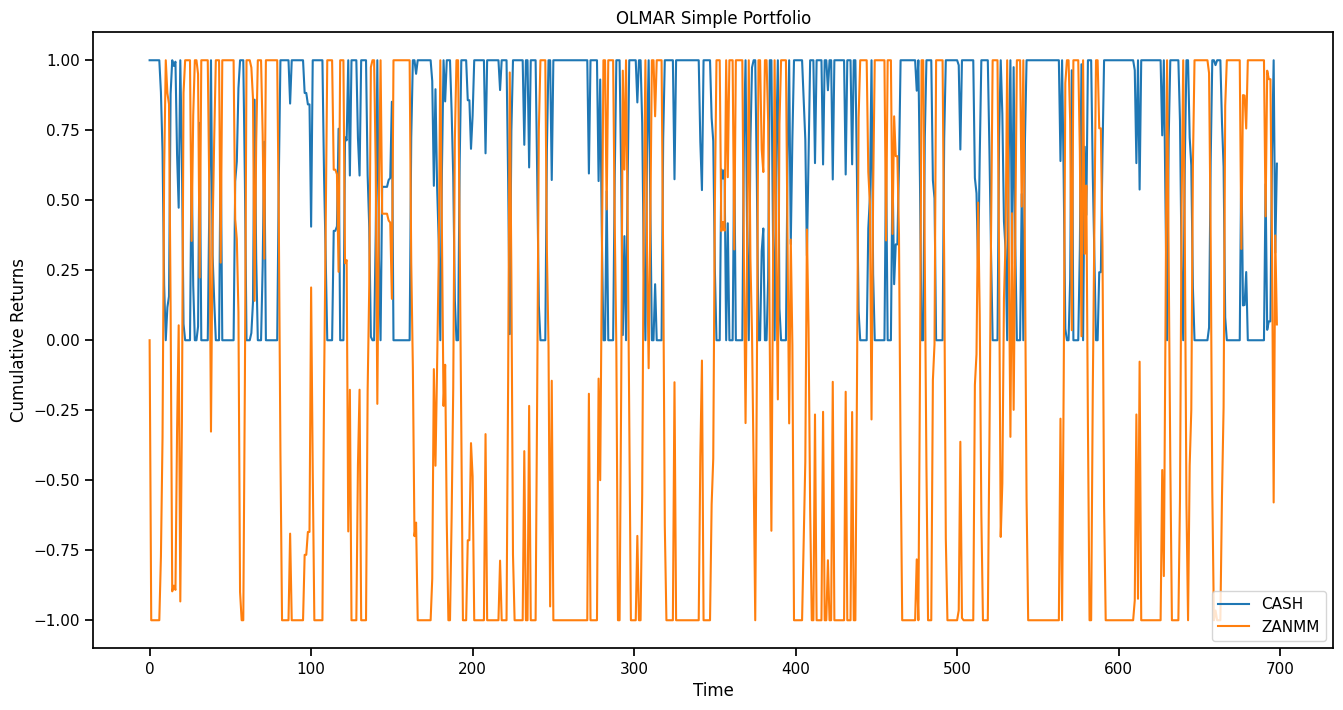

In [300]:
portfolio=pd.DataFrame(OMAR_simple,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('OLMAR Simple Portfolio')

Text(0.5, 1.0, 'OLMAR Exponential Portfolio')

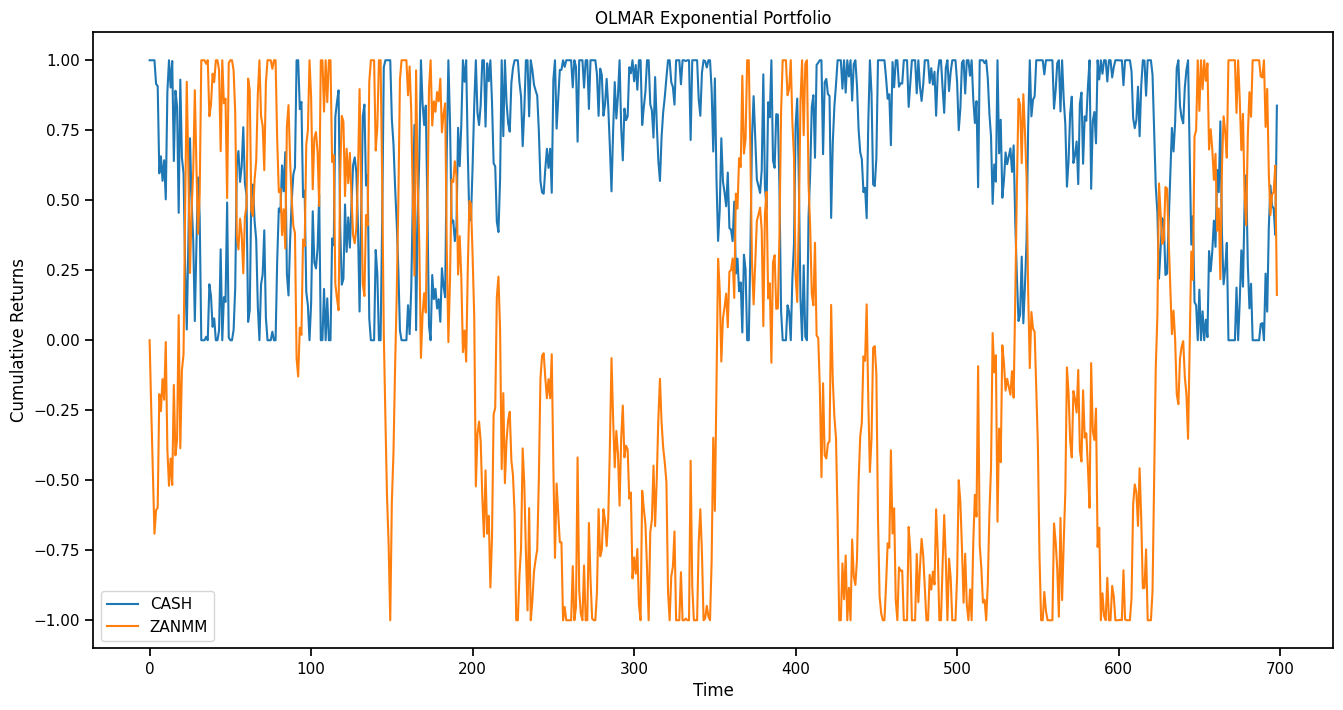

In [301]:
portfolio=pd.DataFrame(OMAR_exp,columns=["CASH"]+dummy_stocks)
ax = portfolio.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('OLMAR Exponential Portfolio')

Text(0.5, 1.0, 'Simulation Performance')

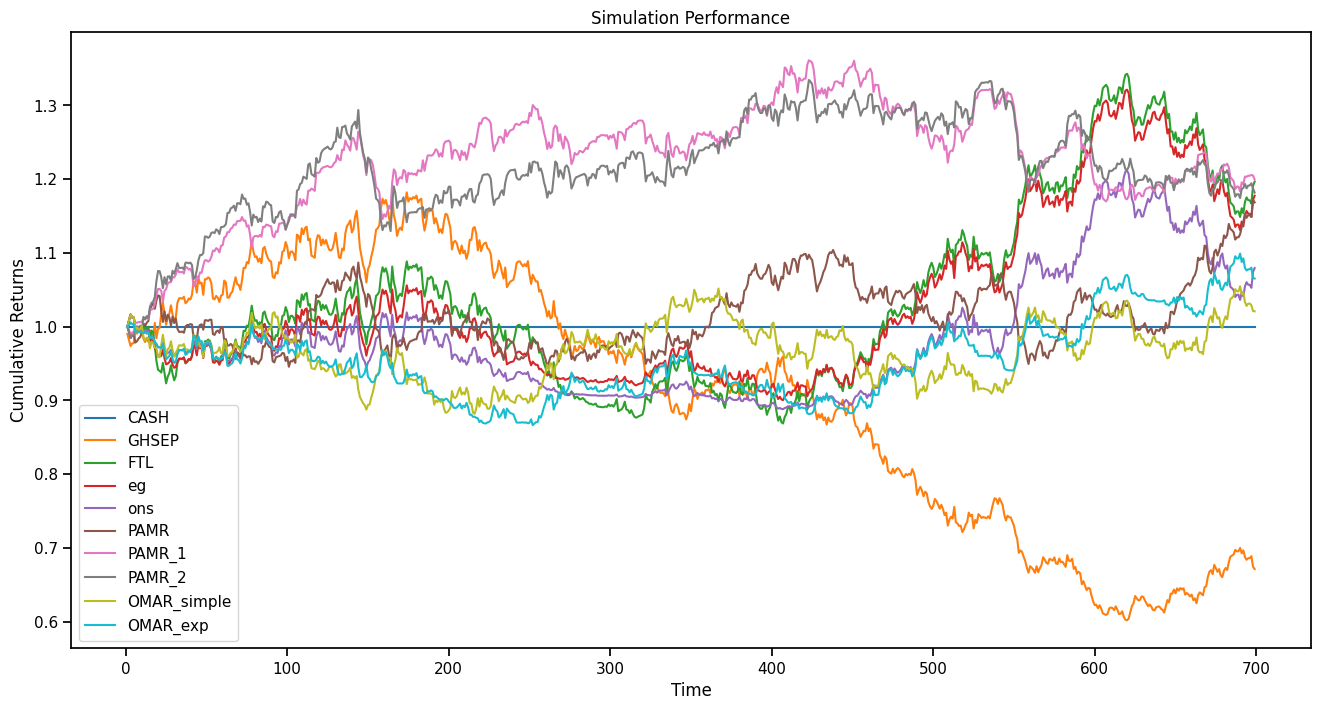

In [302]:
ax = df.plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Simulation Performance')


### Backtesting using Real Market Data

#### Collection of data from refintiv

For backtesting, 25 sector ETFs was used along with SPY and cash as the universe. One minute interval data was obtained for a year from 2022-04-11 till 2023-04-10.
Intraday strategy was built in a way such that at start of each day, portfolio starts with full weight on cash asset.

In [ ]:
def get_intraday_ohlc(asset, start_date = '2023-02-01', end_date = '2023-04-10'):
    start_date_ = pd.to_datetime(start_date, dayfirst=True)
    end_date_ = (start_date_ + pd.Timedelta(days=60)).strftime('%Y-%m-%d')
    end_date_ = min(end_date_, end_date)
    start_date_ = start_date_.strftime('%Y-%m-%d')
    start = True

    while(start_date_ < end_date):
        if start:
            master_df = ek.get_timeseries(asset, interval='minute', start_date=start_date_, end_date=end_date_)
            start = False

        else:
            master_df = pd.concat([master_df, ek.get_timeseries(asset, interval='minute', start_date=start_date_, end_date=end_date_)])
        start_date_v2 = pd.to_datetime(start_date_, dayfirst=True)
        start_date_ = (start_date_v2 + pd.Timedelta(days=61)).strftime('%Y-%m-%d')
        end_date_ = (start_date_v2 + pd.Timedelta(days=121)).strftime('%Y-%m-%d')
    return master_df

def get_intraday_close(assets, start_date = '2023-02-01', end_date = '2023-04-10'):
    index = pd.date_range(start=start_date+' 00:00:00', end=end_date+' 23:59:00', freq='T')
    # master_master = pd.DataFrame(index=index).between_time('9:30', '16:00')
    master_master = pd.DataFrame()
    for asset in assets:
        start_date_ = pd.to_datetime(start_date, dayfirst=True)
        end_date_ = (start_date_ + pd.Timedelta(days=60)).strftime('%Y-%m-%d')
        end_date_ = min(end_date_, end_date)
        start_date_ = start_date_.strftime('%Y-%m-%d')
        start = True

        while(start_date_ < end_date):
            if start:
                master_df = ek.get_timeseries(asset, fields='CLOSE', interval='minute', start_date=start_date_, end_date=end_date_).between_time('9:30', '16:00')
                start = False

            else:
                master_df = pd.concat([master_df, ek.get_timeseries(asset, fields='CLOSE', interval='minute', start_date=start_date_, end_date=end_date_).between_time('9:30', '16:00')])
            start_date_v2 = pd.to_datetime(start_date_, dayfirst=True)
            start_date_ = (start_date_v2 + pd.Timedelta(days=61)).strftime('%Y-%m-%d')
            end_date_ = (start_date_v2 + pd.Timedelta(days=121)).strftime('%Y-%m-%d')
        master_df.columns = [asset]
        # print('')
        print(asset)
        master_master = pd.merge(master_master, master_df, left_index=True, right_index=True, how='outer')

    return master_master

# def get_intraday_price(assets, start_date = '2023-02-01', end_date = '2023-04-10'):
#     start = True
#     for asset in assets:
#         if start:


In [ ]:
assets = ['SPY', 'XLE','XLF','XLU','XLI','GDX','XLK','XLV','XLY','XLP','XLB','XOP','IYR','XHB','ITB','VNQ','GDXJ.K','IYE','OIH','XME','XRT','SMH.O','IBB.O','KBE','KRE','XTL']
data_master = get_intraday_close(assets, start_date = '2022-04-11', end_date = '2023-04-11')


The data collected from above cell was stored in offline file which was used for backtesting

In [187]:
market_data = pd.read_csv('intraday_data.csv', index_col=0).fillna(method='ffill')
data = market_data.loc[market_data.index >= '2022-04-12']
data = data.loc[data.index <= '2023-04-07']
data

,SPY,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,...,GDXJ.K,IYE,OIH,XME,XRT,SMH.O,IBB.O,KBE,KRE,XTL
2022-04-12 09:30:00,439.72,77.62,37.690,76.3400,99.640,39.2400,148.58,141.180,177.10,78.680,...,47.9725,41.34,286.330,60.82,76.88,242.18,131.1200,50.05,65.760,90.370
2022-04-12 09:31:00,439.75,77.62,37.690,76.3400,99.640,39.2400,148.58,141.180,177.10,78.680,...,47.9725,41.34,286.330,60.82,76.88,242.18,131.1200,50.05,65.760,90.370
2022-04-12 09:32:00,439.75,77.99,37.700,76.3400,99.640,39.2400,148.58,141.180,177.10,78.680,...,47.9725,41.34,286.330,60.82,76.88,242.18,131.1200,50.05,65.760,90.370
2022-04-12 09:33:00,439.88,77.72,37.710,76.3400,99.640,39.2400,148.58,141.180,177.10,78.680,...,47.9725,41.34,286.330,60.82,76.88,242.18,130.1900,50.05,65.760,90.370
2022-04-12 09:34:00,439.75,77.72,37.700,76.3400,99.640,39.2400,148.58,141.180,177.10,78.680,...,47.9725,41.34,286.330,60.82,76.88,242.18,130.1900,50.05,65.760,90.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06 15:56:00,408.03,85.52,31.920,69.4100,97.835,34.3500,148.42,133.310,144.58,75.260,...,41.3900,45.00,279.620,51.37,61.45,253.53,130.6200,36.19,42.535,79.063
2023-04-06 15:57:00,408.02,85.58,31.915,69.4400,97.835,34.3600,148.40,133.305,144.58,75.280,...,41.4100,45.03,279.620,51.38,61.45,253.36,130.6101,36.20,42.530,79.063
2023-04-06 15:58:00,408.01,85.59,31.920,69.4300,97.830,34.3500,148.42,133.300,144.55,75.260,...,41.4000,45.04,279.925,51.37,61.43,253.44,130.6400,36.20,42.520,79.063
2023-04-06 15:59:00,408.05,85.61,31.915,69.4335,97.810,34.3579,148.47,133.300,144.58,75.245,...,41.3900,45.05,279.910,51.35,61.44,253.54,130.6600,36.18,42.500,79.063


In [188]:
assets = ['XLE','XLF','XLU','XLI','GDX','XLK','XLV','XLY','XLP','XLB','XOP','IYR','XHB','ITB','VNQ','GDXJ.K','IYE','OIH','XME','XRT','SMH.O','IBB.O','KBE','KRE','XTL', 'SPY']
data['CASH'] = 1
data = data.iloc[:-1]
data = data.loc[:, ['CASH'] + assets]
data.pct_change()
# data

,CASH,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,...,IYE,OIH,XME,XRT,SMH.O,IBB.O,KBE,KRE,XTL,SPY
2022-04-12 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-12 09:31:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000068
2022-04-12 09:32:00,0.0,0.004767,0.000265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2022-04-12 09:33:00,0.0,-0.003462,0.000265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007093,0.000000,0.000000,0.0,0.000296
2022-04-12 09:34:00,0.0,0.000000,-0.000265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06 15:55:00,0.0,0.000585,0.000313,0.000288,0.000154,0.000438,-0.000067,-0.000075,-0.000069,0.000133,...,0.000000,0.001506,0.000390,-0.000326,-0.000073,0.000077,0.000277,0.000000,0.0,0.000123
2023-04-06 15:56:00,0.0,0.000702,0.000345,0.000000,0.000614,0.001604,0.000202,0.000225,0.000346,0.000000,...,0.001112,0.001074,0.001755,0.001140,0.000395,0.000689,0.000553,0.000941,0.0,0.000319
2023-04-06 15:57:00,0.0,0.000702,-0.000157,0.000432,0.000000,0.000291,-0.000135,-0.000038,0.000000,0.000266,...,0.000667,0.000000,0.000195,0.000000,-0.000671,-0.000076,0.000276,-0.000118,0.0,-0.000025
2023-04-06 15:58:00,0.0,0.000117,0.000157,-0.000144,-0.000051,-0.000291,0.000135,-0.000038,-0.000207,-0.000266,...,0.000222,0.001091,-0.000195,-0.000325,0.000316,0.000229,0.000000,-0.000235,0.0,-0.000025


In [ ]:
# Calculating returns

assets = ['CASH'] + assets
df = 1+data[assets].pct_change().dropna()
df.index = pd.to_datetime(df.index)
r = df.to_numpy()
df_ = df.cumprod(axis=0)

df_

To ensure market operating days and time are considered, the data was cleaned to ensure only the market hours were considered.
This is to ensure all trading holidays and trading half-days were taken into consideration in the data.

In [192]:

start_date = '2022-04-12'
end_date = '2023-04-06'
# Create a calendar
nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date=start_date, end_date=end_date)

early['market_open'] = (early.market_open.dt.tz_convert('US/Eastern'))
early['market_close'] = (early.market_close.dt.tz_convert('US/Eastern'))
early

,market_open,market_close
2022-04-12,2022-04-12 09:30:00-04:00,2022-04-12 16:00:00-04:00
2022-04-13,2022-04-13 09:30:00-04:00,2022-04-13 16:00:00-04:00
2022-04-14,2022-04-14 09:30:00-04:00,2022-04-14 16:00:00-04:00
2022-04-18,2022-04-18 09:30:00-04:00,2022-04-18 16:00:00-04:00
2022-04-19,2022-04-19 09:30:00-04:00,2022-04-19 16:00:00-04:00
...,...,...
2023-03-31,2023-03-31 09:30:00-04:00,2023-03-31 16:00:00-04:00
2023-04-03,2023-04-03 09:30:00-04:00,2023-04-03 16:00:00-04:00
2023-04-04,2023-04-04 09:30:00-04:00,2023-04-04 16:00:00-04:00
2023-04-05,2023-04-05 09:30:00-04:00,2023-04-05 16:00:00-04:00


In [190]:
returns_df = pd.DataFrame(index=pd.to_datetime(df_.index).strftime('%Y-%m-%d').unique())
returns_df

""
2022-04-12
2022-04-13
2022-04-14
2022-04-15
2022-04-18
...
2023-03-31
2023-04-03
2023-04-04
2023-04-05


##### Benchmark
Equal weighted portfolio was considered as a benchmark

In [193]:
T = r.shape[0]
n = r.shape[1]
equal_weighted = np.ones((T, n))*1/n
returns_df['equal_weighted'] = None
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    equal_weighted = np.ones((T, n))*1/n
    returns_df.loc[date]['equal_weighted'] = np.cumprod(np.sum(r*equal_weighted, axis=1))[-1]
returns_df

,equal_weighted
2022-04-12,1.012334
2022-04-13,0.997037
2022-04-14,1.001019
2022-04-15,None
2022-04-18,0.997788
...,...
2023-03-31,1.009313
2023-04-03,1.010304
2023-04-04,0.989707
2023-04-05,0.998896


##### Online Moving Average - Simple Mean

In [209]:
returns_df['OMAR_simple'] = None
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    OMAR_simple = Online_Moving_Average_Reversion(r, epsilon = 1.00, window_size = 90, alpha = None)
    returns_df.loc[date]['OMAR_simple'] = np.cumprod(1 + np.sum((r - 1)*OMAR_simple, axis = 1))[-1]
returns_df

,equal_weighted,OMAR_simple,OMAR_exp
2022-04-12,1.012334,0.995888,0.999948
2022-04-13,0.997037,1.000096,0.999994
2022-04-14,1.001019,1.000228,0.999998
2022-04-15,None,None,None
2022-04-18,0.997788,1.000093,1.0
...,...,...,...
2023-03-31,1.009313,0.999856,None
2023-04-03,1.010304,1.000089,None
2023-04-04,0.989707,1.000137,None
2023-04-05,0.998896,1.000095,None


##### Online Moving Average - Exponential Mean

In [215]:
returns_df['OMAR_exp'] = None
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    OMAR_exp = Online_Moving_Average_Reversion(r, epsilon = 1.00, alpha = 0.95)
    returns_df.loc[date]['OMAR_exp'] = np.cumprod(1 + np.sum((r - 1)*OMAR_exp, axis = 1))[-1]

returns_df

,equal_weighted,OMAR_simple,OMAR_exp
2022-04-12,1.012334,0.995888,0.997679
2022-04-13,0.997037,1.000096,1.011027
2022-04-14,1.001019,1.000228,0.996067
2022-04-15,None,None,None
2022-04-18,0.997788,1.000093,1.007125
...,...,...,...
2023-03-31,1.009313,0.999856,0.998076
2023-04-03,1.010304,1.000089,0.993954
2023-04-04,0.989707,1.000137,0.997932
2023-04-05,0.998896,1.000095,1.000376


##### Passive-Aggresive Mean Reversion - Vanilla version

In [223]:
returns_df['PAMR'] = None

# pamr_weights = []
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    pamr = PAMR(r, epsilon=0.98, C=0, type='pamr')
    # pamr_weights.append(pamr)
    returns_df.loc[date]['PAMR'] = np.cumprod(1 + np.sum((r - 1) * pamr, axis=1))[-1]


##### Passive-Aggresive Mean Reversion - Regularised version 1

In [224]:
returns_df['PAMR_1'] = None
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    pamr_1 = PAMR(r, epsilon = 0.98, C = 1, type = 'pamr_1')
    returns_df.loc[date]['PAMR_1'] = np.cumprod(1 + np.sum((r - 1)*pamr_1, axis = 1))[-1]
print('Done')
returns_df

Done


,equal_weighted,OMAR_simple,OMAR_exp,PAMR,PAMR_1
2022-04-12,1.012334,0.995888,0.997679,1.059826,1.001974
2022-04-13,0.997037,1.000096,1.011027,1.031008,1.002326
2022-04-14,1.001019,1.000228,0.996067,1.033854,1.002278
2022-04-15,None,None,None,None,None
2022-04-18,0.997788,1.000093,1.007125,1.058702,1.002877
...,...,...,...,...,...
2023-03-31,1.009313,0.999856,0.998076,1.057844,1.001233
2023-04-03,1.010304,1.000089,0.993954,1.066742,1.009205
2023-04-04,0.989707,1.000137,0.997932,1.02897,1.002676
2023-04-05,0.998896,1.000095,1.000376,1.026174,1.003233


##### Passive-Aggresive Mean Reversion - Regularised version 2

In [225]:
returns_df['PAMR_2'] = None
for date in returns_df.index:
    if date not in early.index:
        continue
    df_temp = (df[df.index.strftime('%Y-%m-%d') == date])
    start_time = early.loc[date]['market_open'].strftime('%H:%M')
    end_time = early.loc[date]['market_close'].strftime('%H:%M')
    df_temp = df_temp.between_time(start_time, end_time)
    r = df_temp.to_numpy()
    T = r.shape[0]
    n = r.shape[1]
    pamr_2 = PAMR(r, epsilon = 0.98, C = 1, type = 'pamr_2')
    returns_df.loc[date]['PAMR_2'] = np.cumprod(1 + np.sum((r - 1)*pamr_2, axis = 1))[-1]
returns_df

,equal_weighted,OMAR_simple,OMAR_exp,PAMR,PAMR_1,PAMR_2
2022-04-12,1.012334,0.995888,0.997679,1.059826,1.001974,1.000051
2022-04-13,0.997037,1.000096,1.011027,1.031008,1.002326,1.00009
2022-04-14,1.001019,1.000228,0.996067,1.033854,1.002278,1.00009
2022-04-15,None,None,None,None,None,None
2022-04-18,0.997788,1.000093,1.007125,1.058702,1.002877,1.000134
...,...,...,...,...,...,...
2023-03-31,1.009313,0.999856,0.998076,1.057844,1.001233,1.000032
2023-04-03,1.010304,1.000089,0.993954,1.066742,1.009205,1.000353
2023-04-04,0.989707,1.000137,0.997932,1.02897,1.002676,1.00012
2023-04-05,0.998896,1.000095,1.000376,1.026174,1.003233,1.000131


Text(0.5, 1.0, 'Backtesting Performance')

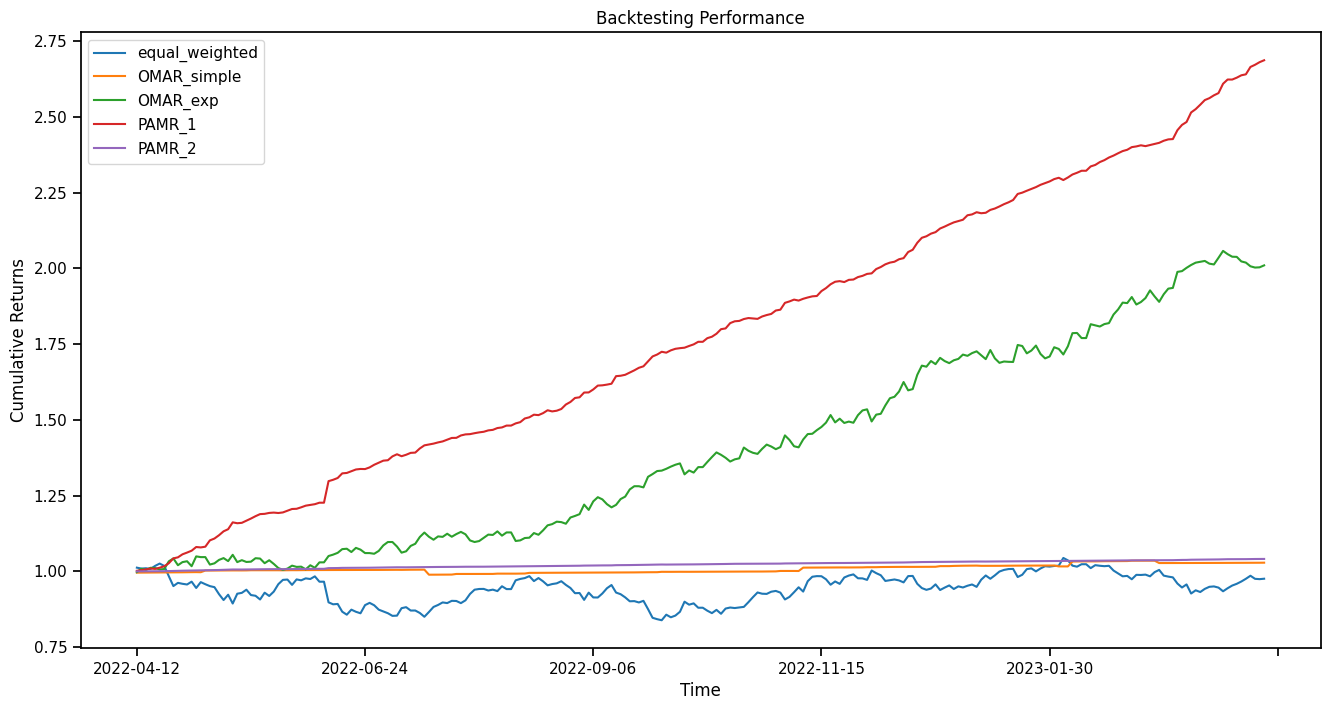

In [304]:
ax = returns_df[['equal_weighted', 'OMAR_simple', 'OMAR_exp', 'PAMR_1', 'PAMR_2']].dropna().cumprod().plot()
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
ax.set_title('Backtesting Performance')

#### Metrics Calculation for backtesting

In [235]:
# Date range
start = '2022-04-11'
end = '2023-04-06'

# Tickers of assets
assets = ['SPY']
n = len(assets)
assets.sort()
# Downloading data
indexdata = yf.download(assets, start = start, end = end)
indexdata = indexdata[['Adj Close']]
indexdata.columns = assets
daily_returns=data[assets].pct_change().dropna()
# daily_returns['SPY']=(indexdata[assets].pct_change().dropna())['SPY']
# Calculating returns

stockindex = 1+indexdata[assets].pct_change().dropna()
#Risk free rate using 0 - 3 month TSY bond ETF
#rf=stockindex['SGOV'].mean()-1
#r1 = stockindex.to_numpy()
stockindex = stockindex.cumprod(axis=0)

# df['SPY']=stockindex['SPY']


[*********************100%***********************]  1 of 1 completed


In [249]:
strategies = returns_df.columns
strategies = strategies.delete(3)
import statsmodels.api as sm
def treynor_ratio(X,Y):
    X1=X.loc[X.index.intersection(Y.index)]
    Y1=Y.loc[X.index.intersection(Y.index)]
    X1_const = sm.add_constant(X1)
    model = sm.OLS(Y1, X1_const)
    results = model.fit()
    stdev = np.std(Y1 - (results.params[1] * X1 + results.params[0]), ddof=1)
    IR = results.params[0] / stdev
    TR = Y1.mean()/results.params[1]
    Beta = results.params[1]
    alpha = results.params[0]
    return (IR,TR,Beta,alpha)


daily_returns = returns_df - 1
daily_returns['SPY'] = indexdata['SPY'].pct_change()
df = returns_df.cumprod()
metrics = pd.DataFrame(index=strategies)
for col in strategies:
    metrics.loc[col, 'mean ret'] = daily_returns[col].mean() * 252
    metrics.loc[col, 'win_loss_ratio'] = (daily_returns[col] > 0).mean()
    metrics.loc[col, 'volatility'] = daily_returns[col].std() * (252 ** 0.5)
    metrics.loc[col, 'Sharpe ratio'] = metrics.loc[col, 'mean ret'] / metrics.loc[col, 'volatility']
    metrics.loc[col, 'daily var'] = daily_returns[col].quantile(0.05)
    quantile = daily_returns[col].quantile(0.05)
    metrics.loc[col, 'daily cvar'] = daily_returns.loc[daily_returns[col] < quantile][col].mean()
    metrics.loc[col,'drawdown']=abs((df[col]-df[col].cummax()).min())
    metrics.loc[col,'cum ret'] = df[col].iloc[-1]-1
    metrics.loc[col,'Calmar Ratio']=(daily_returns[col].mean() * 252)/abs(metrics.loc[col,'drawdown'])
    downside_dev = daily_returns[daily_returns[col]<0][col].std()* (252 ** 0.5)
    metrics.loc[col,'Sortino Ratio']=daily_returns[col].mean() * 252/downside_dev
    # if col!='SPY':
    #     metrics.loc[col,'IR'],metrics.loc[col,'TR'],metrics.loc[col,'Beta'],alpha=treynor_ratio(daily_returns['SPY'].dropna(),daily_returns[col].dropna())
    #     metrics.loc[col,'Annual Alpha']=alpha*252


In [250]:
metrics.transpose()

,equal_weighted,OMAR_simple,OMAR_exp,PAMR_1,PAMR_2
mean ret,0.001797,0.029224,0.725852,1.009121,0.040980
win_loss_ratio,0.488372,0.693798,0.569767,0.879845,0.868217
volatility,0.230892,0.028290,0.177187,0.077940,0.003241
Sharpe ratio,0.007782,1.033013,4.096529,12.947386,12.645182
daily var,-0.024334,-0.000165,-0.015381,-0.000859,-0.000052
daily cvar,-0.032246,-0.002576,-0.020209,-0.001922,-0.000115
drawdown,0.187025,0.016757,0.054919,0.007530,0.000208
cum ret,-0.024168,0.028772,1.009741,1.686449,0.041145
Calmar Ratio,0.009607,1.744019,13.216878,134.015866,197.342789
Sortino Ratio,0.011380,0.801065,7.180794,56.178523,47.422810


In [254]:
returns_df.to_csv('final_results.csv')